In [1]:
import os

import tensorflow as tf
print(tf.version.VERSION)

import tensorflow.keras.layers as layers

from sklearn.model_selection import train_test_split

import albumentations as A
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

2.10.0


In [2]:
train, test = tf.keras.datasets.fashion_mnist.load_data()

In [3]:
images, labels = train
images = images/255.0
labels = labels.astype(np.int32)

In [4]:
X_train, X_test, y_train, y_test = \
    train_test_split(images, labels, test_size=0.1)

# make dataset from the list
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))

# set batch_size na 32 and shuffle 1000
train_ds = train_ds.shuffle(1000).batch(32)

In [5]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH = X_train.shape[2]

In [6]:
# Define a simple sequential model
def create_model():
  model = tf.keras.models.Sequential([
      layers.Conv2D(512, 3, padding='same', kernel_initializer='he_uniform', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,1)),
      layers.MaxPool2D(),
      layers.Conv2D(64, 3, padding='same', kernel_initializer='he_uniform', activation='relu'),
      layers.MaxPool2D(),
      layers.Conv2D(32, 3, padding='same', kernel_initializer='he_uniform', activation='relu'),
      layers.MaxPool2D(),
      layers.Flatten(),
      layers.Dense(16, activation='relu', kernel_initializer='he_uniform',),
      layers.Dense(10, activation='softmax')
  ])

  model.compile(optimizer='adam',
                loss=tf.losses.SparseCategoricalCrossentropy(),
                metrics=[tf.metrics.SparseCategoricalAccuracy()])

  return model

# Create a basic model instance
model = create_model()

# Display the model's architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 512)       5120      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 512)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        294976    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 32)          18464     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 3, 3, 32)         0

In [9]:
# Include the epoch in the file name (uses `str.format`)
checkpoint_path = "training_2/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

batch_size = 32

# Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq=5*batch_size)

# Create a new model instance
model = create_model()

# Save the weights using the `checkpoint_path` format
model.save_weights(checkpoint_path.format(epoch=0))

# Train the model with the new callback
model_hist = model.fit(train_ds,
                       epochs=7,
                       batch_size=batch_size,
                       validation_data=(X_test, y_test),
                       callbacks=[cp_callback]) # Pass callback to training  
                    

# This may generate warnings related to saving the state of the optimizer.
# These warnings (and similar warnings throughout this notebook)
# are in place to discourage outdated usage, and can be ignored.


# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model.save('my_model.h5')

Epoch 1/7
 159/1688 [=>............................] - ETA: 3:25 - loss: 1.0514 - sparse_categorical_accuracy: 0.6281
Epoch 1: saving model to training_2\cp-0001.ckpt
 319/1688 [====>.........................] - ETA: 3:08 - loss: 0.8380 - sparse_categorical_accuracy: 0.7053
Epoch 1: saving model to training_2\cp-0001.ckpt
 479/1688 [=======>......................] - ETA: 2:46 - loss: 0.7305 - sparse_categorical_accuracy: 0.7439
Epoch 1: saving model to training_2\cp-0001.ckpt
 639/1688 [==========>...................] - ETA: 2:16 - loss: 0.6693 - sparse_categorical_accuracy: 0.7660
Epoch 1: saving model to training_2\cp-0001.ckpt
 799/1688 [=============>................] - ETA: 1:52 - loss: 0.6298 - sparse_categorical_accuracy: 0.7807
Epoch 1: saving model to training_2\cp-0001.ckpt
 959/1688 [================>.............] - ETA: 1:31 - loss: 0.5950 - sparse_categorical_accuracy: 0.7932
Epoch 1: saving model to training_2\cp-0001.ckpt
1119/1688 [==================>...........] - ETA

In [10]:
model_hist.history.keys()

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])

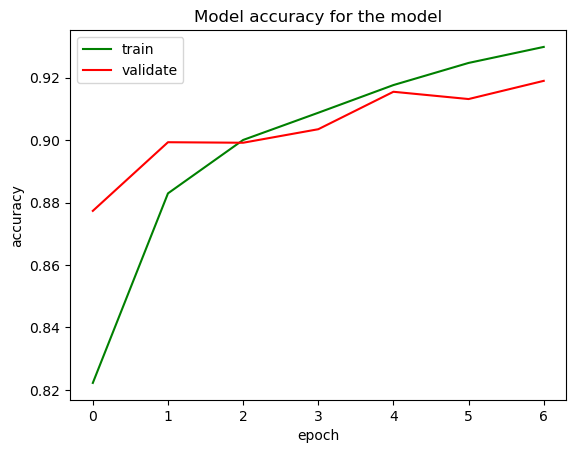

In [11]:
#Plot accuracy results for training data and testing data 
plt.plot(model_hist.history['sparse_categorical_accuracy'], 'green')
plt.plot(model_hist.history['val_sparse_categorical_accuracy'], 'red')
plt.title('Model accuracy for the model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')

In [12]:
def check(model, x, n):
    labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress',
              'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
    y_pred = model.predict(x)
    
    imgplot = plt.imshow(X_test[n])
    plt.show()
    print(f"Model predicts: {labels[np.argmax(y_pred[n])]} - {np.argmax(y_pred[n])}/{y_test[n]}")

188/188 [==============================] - 3s 13ms/step


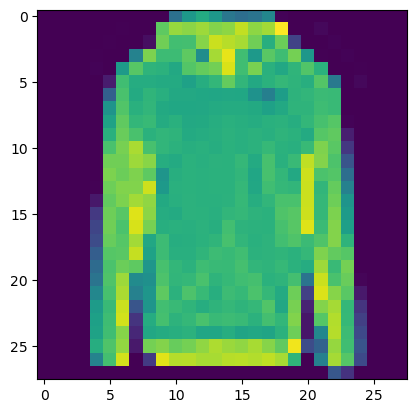

Model predicts: Coat - 4/4


In [13]:
check(model, X_test, 1)

In [14]:
from PIL import Image
from matplotlib import cm
im = Image.fromarray(np.uint8(cm.gist_earth(X_test[0])*255))
im

In [15]:
def view_image(ds):
    image, label = next(iter(ds)) # extract 1 batch from the dataset
    image = image.numpy()
    label = label.numpy()
    
    fig = plt.figure(figsize=(28, 28))
    for i in range(20):
        ax = fig.add_subplot(4, 5, i+1, xticks=[], yticks=[])
        ax.imshow(Image.fromarray(np.uint8(cm.gist_earth(image[i])*255)))
        ax.set_title(f"Label: {label[i]}")

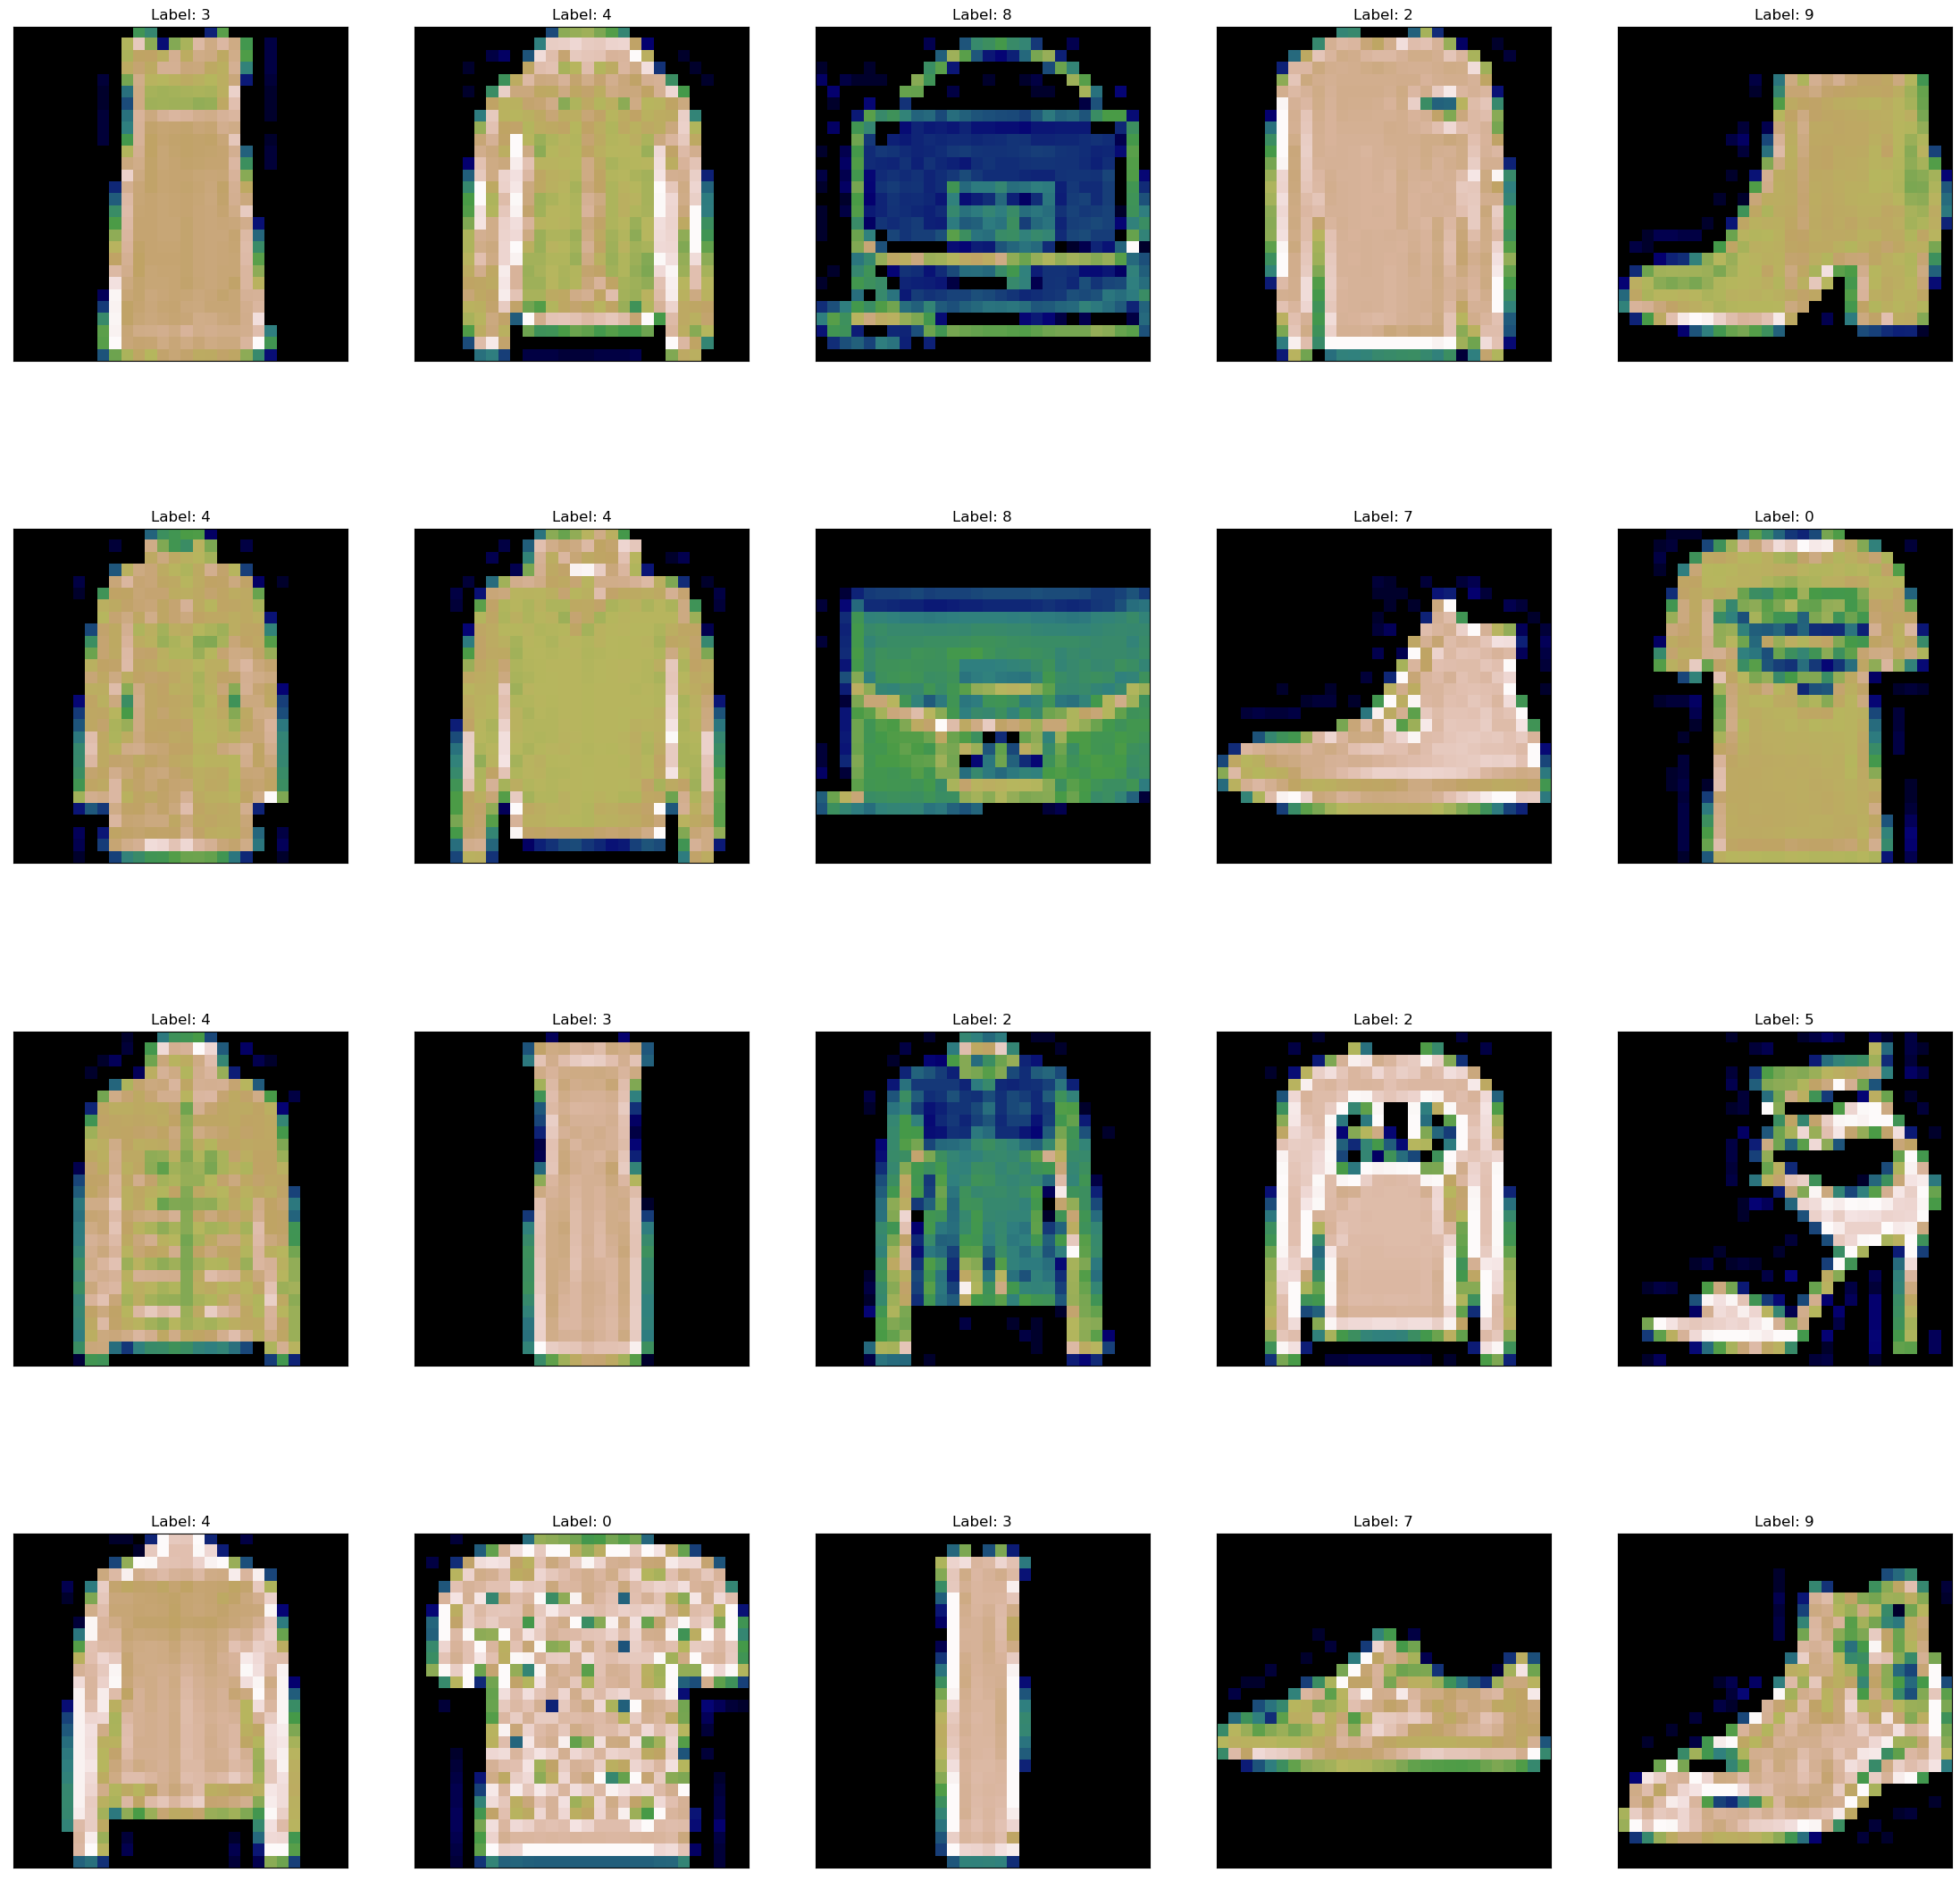

In [16]:
view_image(train_ds)

In [17]:
# necessary imports
import albumentations as A

In [18]:
images, labels = train
images = images/ 255
labels = labels.astype(np.int32)

In [19]:
image = X_test[3]

In [20]:
def visualize(image):
    plt.figure(figsize=(1, 1), dpi=75)
    plt.axis('off')
    plt.imshow(image)

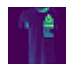

In [21]:
from skimage import img_as_ubyte
cv_image = img_as_ubyte(image)
visualize(cv_image)

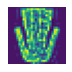

In [31]:
transform = A.Compose([
        A.RandomRotate90(),
        A.Flip(),
        A.Transpose(),
        A.OneOf([
            A.IAAAdditiveGaussianNoise(),
            A.GaussNoise(),
        ], p=0.2),
        A.OneOf([
            A.MotionBlur(p=.2),
            A.MedianBlur(blur_limit=3, p=0.1),
            A.Blur(blur_limit=3, p=0.1),
        ], p=0.2),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2),
        A.OneOf([
            A.OpticalDistortion(p=0.3),
            A.GridDistortion(p=.1),
            A.IAAPiecewiseAffine(p=0.3),
        ], p=0.2),
        A.OneOf([
            A.CLAHE(clip_limit=2),
            A.IAASharpen(),
            A.IAAEmboss(),
            A.RandomBrightnessContrast(),            
        ], p=0.3),
        A.HueSaturationValue(hue_shift_limit=0, sat_shift_limit=0, p=0.3),
    ])
np.random.seed(42) 
augmented_image = transform(image=cv_image)['image']
visualize(augmented_image)

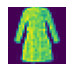

In [32]:
cv_image = img_as_ubyte(X_train[3])
visualize(cv_image)

In [33]:
def new_dataset(x):
    X_train = []

    for image in x:
        cv_image = img_as_ubyte(image)
        augmented_image = transform(image=cv_image)['image']
        X_train.append(augmented_image)
        
    return X_train

In [34]:
new_X_train = new_dataset(X_train)

In [35]:
new_X_test = new_dataset(X_test)

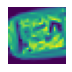

In [46]:
visualize(new_X_train[142])

In [47]:
y_train[12]

8

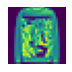

In [48]:
visualize(X_train[142])

In [49]:
# make dataset from the list
train_ds = tf.data.Dataset.from_tensor_slices((new_X_train, y_train))

# set batch_size na 32 and shuffle 1000
new_train_ds = train_ds.shuffle(1000).batch(32)

In [50]:
# Recreate the exact same model, including its weights and the optimizer
new_model = tf.keras.models.load_model('my_model.h5')

# Show the model architecture
new_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 28, 28, 512)       5120      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 14, 14, 512)      0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 14, 14, 64)        294976    
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 7, 7, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 7, 7, 32)          18464     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 3, 3, 32)        

In [51]:
loss, acc = new_model.evaluate(X_test, y_test, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

188/188 - 3s - loss: 0.2444 - sparse_categorical_accuracy: 0.9190 - 3s/epoch - 13ms/step
Restored model, accuracy: 91.90%
